# Best Model

## Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
df_train = pd.read_csv('/Users/maelfabien/Desktop/LocalDB/RSSI/df_mess_train_3.csv')
df_test = pd.read_csv('/Users/maelfabien/Desktop/LocalDB/RSSI/df_mess_test_3.csv')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)
df_train.head()

,messid,did,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,...,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,473335.0,2,0.007640,0.007640,0.007640,0.013217,0.021591,0.097936,0.078317,...,-1.151346,-1.151346,0.335108,0.335108,-0.571009,-0.499647,-0.571009,-0.499647,39.606690,-104.958490
1,573bf3533e952e19126b256a,473335.0,1,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,...,0.857564,0.857564,0.167472,0.167472,-0.291295,-0.255968,-0.291295,-0.255968,39.637741,-104.958554
2,573c0cd0f0fe6e735a699b93,473953.0,3,0.011459,0.011459,0.011459,0.019825,0.032387,0.146905,0.117476,...,-2.184846,-2.184846,0.502798,0.502798,-0.804799,-0.765319,-0.804799,-0.765319,39.730417,-104.968940
3,573c1272f0fe6e735a6cb8bd,476512.0,4,0.015279,0.015279,0.015279,0.026434,0.043183,0.195873,0.156635,...,-0.261038,-0.261038,0.670089,0.670089,-1.162423,-1.033559,-1.162423,-1.033559,39.693102,-105.006995
4,573c8ea8864fce1a9a5fbf7a,476286.0,42,0.160432,0.160432,0.160432,0.277553,0.453421,2.056664,-24.637701,...,0.768993,0.768993,7.036390,7.036390,-11.072712,-10.864657,-11.072712,-10.864657,39.758167,-105.051016


In [8]:
def ground_truth_const(df):
    
    X = df.drop(['messid', 'lat', 'lng', 'did'], axis=1)
    y_lat = df['lat']
    y_lng = df['lng']
    
    return X, y_lat, y_lng

In [9]:
X_train, y_lat_train, y_lng_train = ground_truth_const(df_train)
X_train.head()

,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,rssi8,rssi9,...,lngi258,lngi259,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng
0,2,0.007640,0.007640,0.007640,0.013217,0.021591,0.097936,0.078317,0.044555,0.007640,...,0.155708,0.007640,-1.151346,-1.151346,0.335108,0.335108,-0.571009,-0.499647,-0.571009,-0.499647
1,1,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,0.022277,0.003820,...,0.077854,0.003820,0.857564,0.857564,0.167472,0.167472,-0.291295,-0.255968,-0.291295,-0.255968
2,3,0.011459,0.011459,0.011459,0.019825,0.032387,0.146905,0.117476,0.066832,0.011459,...,0.233561,0.011459,-2.184846,-2.184846,0.502798,0.502798,-0.804799,-0.765319,-0.804799,-0.765319
3,4,0.015279,0.015279,0.015279,0.026434,0.043183,0.195873,0.156635,0.089110,0.015279,...,0.311415,0.015279,-0.261038,-0.261038,0.670089,0.670089,-1.162423,-1.033559,-1.162423,-1.033559
4,42,0.160432,0.160432,0.160432,0.277553,0.453421,2.056664,-24.637701,0.935653,0.160432,...,3.269860,0.160432,0.768993,0.768993,7.036390,7.036390,-11.072712,-10.864657,-11.072712,-10.864657


## Define Accuracy Measure

In [10]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [11]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    #y_pred_lat[np.where(y_pred_lat>90)[0]]=90
    #y_pred_lat[np.where(y_pred_lat<-90)[0]]=-90
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Train the model

In [13]:
ext_lng = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1)
ext_lng.fit(X_train, y_lng_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
ext_lat = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1)
X_train_new = pd.concat([X_train, y_lng_train], axis=1)
ext_lat.fit(X_train_new, y_lat_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

## Cross Val predict Score Assessment

The purpose of this section is to validate the hypothesis we have used so far and have a more robust idea of the accuracy we can expect when predicting on the test set.

In [20]:
ext_lng_cv = ExtraTreesRegressor(n_estimators=1000, n_jobs = -1)
pred_lng = cross_val_predict(ext_lng_cv, X_train, y_lng_train, cv=5)

In [21]:
ext_lat_cv = ExtraTreesRegressor(n_estimators=1000, n_jobs = -1)
X_train_new = pd.concat([X_train, y_lng_train], axis=1)
pred_lat = cross_val_predict(ext_lat_cv, X_train_new, y_lat_train, cv=5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


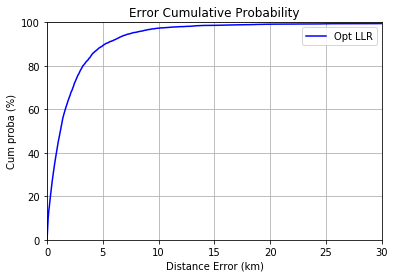

3209.6056741746634


In [22]:
err_vec = Eval_geoloc(y_lat_train , y_lng_train, pred_lat, pred_lng)

#err_vec = Eval_geoloc(y_test['lat'] , y_test['lng'], pred['lat_test'], pred['lng_test'])
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

print(np.percentile(err_vec, 80))

## Prediction for the test set

In [17]:
df_test_train = df_test.drop(['messid', 'did'], axis=1)

pred_lng = ext_lng.predict(df_test_train)

new_test = pd.concat([df_test_train.reset_index(drop=True), pd.DataFrame(pred_lng).reset_index(drop=True)], axis=1)
pred_lat = ext_lat.predict(new_test)

test_res = pd.DataFrame(np.array([pred_lat, pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = df_test['messid']
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()


,lat,lng,messid
0,39.707541,-105.037183,573be2503e952e191262c351
1,39.783737,-105.072701,573c05f83e952e1912758013
2,39.687588,-105.010862,573c0796f0fe6e735a66deb3
3,39.789085,-105.079237,573c08d2864fce1a9a0563bc
4,39.689631,-105.009455,573c08ff864fce1a9a0579b0


In [18]:
test_res.shape

(5294, 3)

In [63]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    from sklearn.model_selection import learning_curve
    plt.figure(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt   

<module 'matplotlib.pyplot' from '/Users/maelfabien/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

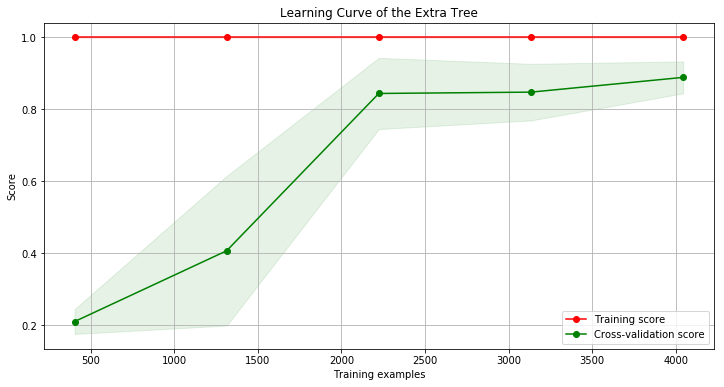

In [64]:
plot_learning_curve(ext_lat, "Learning Curve of the Extra Tree", X_train, y_lat_train)

The cross validation score keeps improving with the number of observations we are given. This is a good sign that we are not overfitting.